<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BF%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B2%D1%85%D0%BE%D0%B4%D1%8F%D1%89%D0%B8%D1%85_%D0%B2%D1%8B%D1%85%D0%BE%D0%B4%D1%8F%D1%89%D0%B8%D1%85_Conv2D_%D0%B8_%D0%BD%D0%B5%D1%81%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B9_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача классификации пассажиров на входящих и выходящих. Исходный датасет несбалансированный: фото входящих в 3 раза больше выходящих.

Добиться точности работы модели выше 90% на тестовой выборке

In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image, ImageEnhance

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

import tensorflow as tf
import math

# Рисование графиков в ячейках Colab
%matplotlib inline

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/bus'       # Папка для обучающего набора данных
TEST_PATH           = '/content/bus_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 96                   # Ширина изображения для нейросети
IMG_HEIGHT          = 192                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 32                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [ ]:
def augment_image(img,                    # Изображение для аугментации
                  ang=8,                  # Максимальный угол поворота
                  f_x=0.15,               # Максимальная подрезка по ширине
                  f_y=0.15,               # Максимальная подрезка по высоте
                  level_contr=0.3,        # Максимальное отклонение коэффициента контраста от нормы
                  level_brght=0.3):       # Максимальное отклонение коэффициента яркости от нормы


    # Функция нахождения ширины и высоты прямоугольника наибольшей площади
    # после поворота заданного прямоугольника на угол в градусах

    def rotated_rect(w, h, angle):
        angle = math.radians(angle)
        width_is_longer = w >= h
        side_long, side_short = (w,h) if width_is_longer else (h,w)

        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
            x = 0.5 * side_short
            wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
        else:
            cos_2a = cos_a*cos_a - sin_a*sin_a
            wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

        return wr, hr


    # Функция случайной обрезки

    def random_crop(x,                    # Подаваемое изображение
                    f_x=f_x,              # Предел обрезки справа и слева (в масштабе ширины)
                    f_y=f_x               # Предел обрезки сверху и снизу (в масштабе высоты)
                    ):

        # Получение левой и правой границ обрезки
        left = x.width * random.random() * f_x
        right = x.width * (1. - random.random() * f_x) - 1.

        # Получение верхней и нижней границ обрезки
        upper = x.height * random.random() * f_y
        lower = x.height * (1. - random.random() * f_y) - 1.

        return x.crop((left, upper, right, lower))


    # Функция случайного поворота

    def random_rot(x,                     # Подаваемое изображение
                   ang=ang                # Максимальный угол поворота
                   ):

        # Случайное значение угла в диапазоне [-ang, ang]
        a = random.uniform(-1., 1.) * ang

        # Вращение картинки с расширением рамки
        r = x.rotate(a, expand=True)

        # Вычисление размеров прямоугольника обрезки максимальной площади
        # для размеров исходной картинки и угла поворота в градусах
        crop_w, crop_h = rotated_rect(x.width, x.height, a)

        # Обрезка повернутого изображения и возврат результата
        w, h = r.size
        return r.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                       (w + crop_w)*0.5, (h + crop_h)*0.5))


    # Функция отражения

    def trans_img(x):
        return x.transpose(Image.FLIP_LEFT_RIGHT)


    # Функция случайного изменения контрастности

    def random_contrast(x,                   # Подаваемое изображение
                        level=level_contr    # Максимальное отклонение коэффициента контраста от нормы - число от 0. до 1.
                        ):

        enh = ImageEnhance.Contrast(x)       # Создание экземпляра класса Contrast
        factor = random.uniform(1. - level,
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала

        return enh.enhance(factor)           # Изменение коэффициента контраста



    # Функция случайного изменения яркости

    def random_brightness(x,                 # Подаваемое изображение
                        level=level_brght    # Максимальное отклонение коэффициента яркости от нормы - число от 0. до 1.
                        ):

        enh = ImageEnhance.Brightness(x)     # Создание экземпляра класса Brightness
        factor = random.uniform(1. - level,
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала

        return enh.enhance(factor)           # Изменение коэффициента яркости


    # Тело основной функции

    # Cоздание списка модификаций
    mod_oper = [random_rot,
                random_crop,
                trans_img,
                random_contrast,
                random_brightness]

    # Cлучайное количество изменений из списка; минимум одно изменение
    mod_count = random.randrange(len(mod_oper) + 1)

    # Случайный отбор индексов изменений в количестве mod_count без повторений
    mod_list = random.sample(range(len(mod_oper)), mod_count)

    # Применение модификаций по индексам из mod_list
    for mod_index in mod_list:
        img = mod_oper[mod_index](img)

    # Возврат результата
    return img

# Вывод изображений

def show_image(img):
    plt.figure(figsize=(8, 5))            # Cоздание полотна для рисования
    plt.imshow(img)                       # Отрисовка изображения
    plt.axis('off')                       # Отключение ненужных осей
    plt.show()                            # Вывод результата

def show_image_pair(img1, img2):
    # Cоздание полотна для рисования двух изображений
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Исходное изображение
    axs[0].imshow(img1)
    axs[0].axis('off')

    # Модифицированное изображение
    axs[1].imshow(img2)
    axs[1].axis('off')

    # Вывод изображений
    plt.show()

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
#    test_file_count = 600   # Определение числа тестовых файлов для класса
#    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    test_files = random.sample(class_files, test_file_count)            # Выделение случайных файлов для теста
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')

    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    if class_name == 'Входящий':
#        for i in np.random.randint(0,class_file_count, int(class_file_count * 0.05)):
#          img  = Image.open(class_path+'/'+class_files[i])
#          img_new = augment_image(img)
#          img_new.save(class_path+'/'+ '.'.join(class_files[i].split('.')[:-1]) + '_new.jpg',"jpeg")

        in_count = class_file_count

    if class_name == 'Выходящий':
        while int(in_count * 0.7) > class_file_count:
          for i in random.sample(class_files, 2):
            img  = Image.open(class_path+'/'+i)
            img_new = augment_image(img)
            img_new.save(class_path+'/'+ '.'.join(i.split('.')[:-1]) + '_new.jpg',"jpeg")
            class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
            class_file_count = len(class_files)                    # Получение общего числа файлов класса

    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} человек, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Входящий: 5837 человек, для теста выделено файлов: 648
Размер класса Выходящий: 4085 человек, для теста выделено файлов: 259
Общий размер базы: 9922, выделено для обучения: 9015, для теста: 907


In [ ]:
# Генераторы изображений
#train_datagen = ImageDataGenerator(rescale=1. / 255., validation_split=VAL_SPLIT)
train_datagen = ImageDataGenerator(rescale=1. / 255., rotation_range=ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE, zoom_range=ZOOM_RANGE, brightness_range=BRIGHTNESS_RANGE, horizontal_flip=HORIZONTAL_FLIP, validation_split=VAL_SPLIT)
test_datagen = ImageDataGenerator(rescale=1. / 255.)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, subset='training')
validation_generator = train_datagen.flow_from_directory(TRAIN_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, subset='validation')
test_generator = test_datagen.flow_from_directory(TEST_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=test_count, class_mode='categorical', shuffle=True,)

Found 7938 images belonging to 2 classes.
Found 1984 images belonging to 2 classes.
Found 907 images belonging to 2 classes.


In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
#                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    # model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100.0 * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100.0 * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(12, 6),       # размер полотна для графиков обучения
                             cm_size=(6, 6)            # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

Epoch 1/60
249/249 [==============================] - 95s 316ms/step - loss: 0.6472 - accuracy: 0.6691 - val_loss: 0.6437 - val_accuracy: 0.6426
Epoch 2/60
249/249 [==============================] - 78s 312ms/step - loss: 0.4597 - accuracy: 0.7858 - val_loss: 0.6900 - val_accuracy: 0.6658
Epoch 3/60
249/249 [==============================] - 77s 311ms/step - loss: 0.4042 - accuracy: 0.8171 - val_loss: 0.6942 - val_accuracy: 0.6784
Epoch 4/60
249/249 [==============================] - 77s 307ms/step - loss: 0.3710 - accuracy: 0.8386 - val_loss: 0.7931 - val_accuracy: 0.6744
Epoch 5/60
249/249 [==============================] - 76s 305ms/step - loss: 0.3337 - accuracy: 0.8560 - val_loss: 0.6996 - val_accuracy: 0.6789
Epoch 6/60
249/249 [==============================] - 76s 305ms/step - loss: 0.3266 - accuracy: 0.8578 - val_loss: 0.7109 - val_accuracy: 0.6910
Epoch 7/60
249/249 [==============================] - 76s 304ms/step - loss: 0.3048 - accuracy: 0.8696 - val_loss: 0.8811 - val_ac

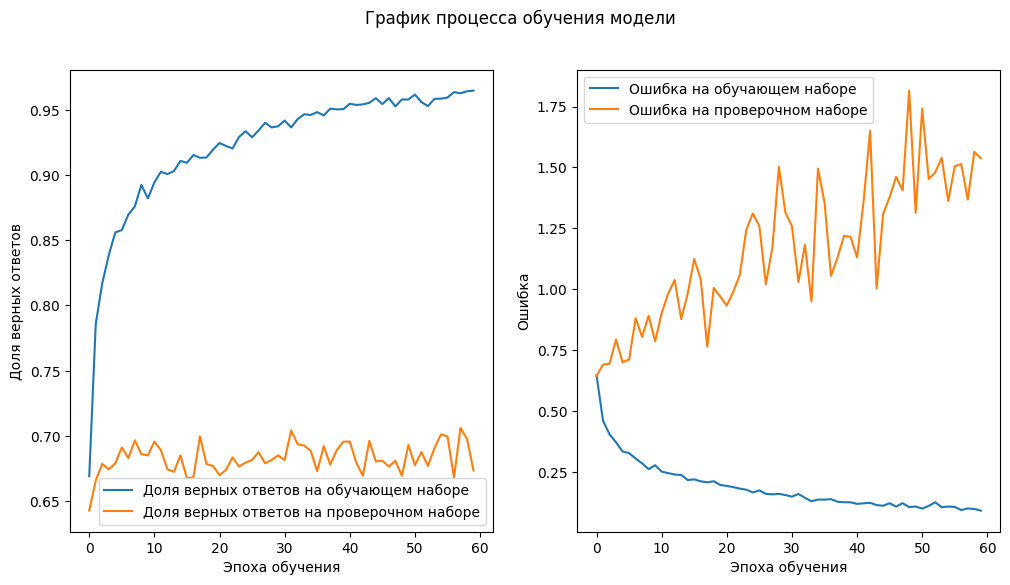

29/29 [==============================] - 1s 46ms/step


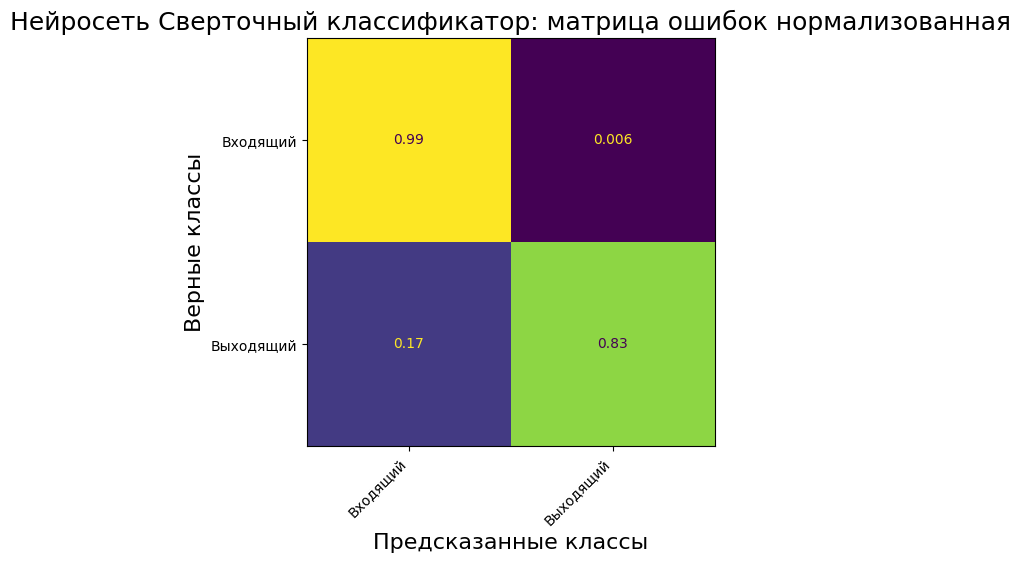

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Входящий              99% сеть отнесла к классу Входящий             - ВЕРНО :-)
Класс: Выходящий             83% сеть отнесла к классу Выходящий            - ВЕРНО :-)

Средняя точность распознавания:  91%


In [ ]:
# Создание последовательной модели
model_conv = Sequential()

model_conv.add(BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
model_conv.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model_conv.add(Conv2D(128, (3, 3), padding='valid', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.4))
model_conv.add(Flatten())
model_conv.add(Dense(800, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(400, activation='relu'))
model_conv.add(Dropout(0.4))
model_conv.add(Dense(200, activation='relu'))
model_conv.add(Dropout(0.4))
model_conv.add(Dense(CLASS_COUNT, activation='sigmoid'))

# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')